In [ ]:
import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [ ]:
# set working directory 
import os
os.chdir("/hpc/group/goldsteinlab/vmd13/Python/250131_TCR_data")

In [ ]:
mdata = mu.read_h5mu("/hpc/group/goldsteinlab/sk733/adata_gex_tcr_onlytcrsequenced_scVI.h5mu")

In [ ]:
mdata

In [ ]:
adata = mdata["gex"]

In [ ]:
adata.write("/hpc/group/goldsteinlab/vmd13/Python/250305_gex_data.h5ad")

In [ ]:
# Using .value_counts()
mdata["gex"].obs["orig_patients"].value_counts()

In [ ]:
mdata["gex"].obs.groupby(["cond", "orig_patients"]).size()


In [ ]:
sc.tl.rank_genes_groups(
    mdata["gex"],
    groupby="cond",            # Use the "cond" column (has "hyposmic"/"normosmic")
    reference="normosmic",     # Compare to "normosmic" as the baseline
    method="wilcoxon",
    layer="norm",
    key_added="wilcoxon_cond"
)

# Extract the DE results for the "hyposmic" group vs. reference
de_df = sc.get.rank_genes_groups_df(
    mdata["gex"], 
    group="hyposmic", 
    key="wilcoxon_cond"
)
de_df.head(30)


In [ ]:
import numpy as np
# 1) Get the full DE dataframe
de_df = sc.get.rank_genes_groups_df(
    mdata["gex"],
    group="hyposmic",
    key="wilcoxon_cond"
)

# 2) Restrict to the 'highly_variable' genes only
de_df = de_df.set_index("names")
de_df = de_df.loc[mdata["gex"].var["highly_variable"]]

# 3) Sort by the absolute value of the Wilcoxon z-score
de_df = de_df.sort_values("scores", key=np.abs, ascending=False)

# 4) Select only the scores column (or keep what you need)
wilcoxon_scores = de_df[["scores"]]

wilcoxon_scores.head()


In [ ]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a .gmt file to a DataFrame with two columns: 
    1) 'geneset'  2) 'genesymbol'.
    """
    from itertools import chain, repeat

    pathways = {}
    with open(pth, "r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes
    
    # Each pathway name can have many genes.
    # We'll return a dataframe with columns [geneset, genesymbol].
    df = pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"]
    )
    return df


# Load the file into a DataFrame
reactome = gmt_to_decoupler("c2.cp.reactome.v2024.1.Hs.symbols.gmt.txt")
reactome.head()


In [ ]:
# Count how many genes per geneset
geneset_size = reactome.groupby("geneset").size()

# Keep only sets with 15–500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

# We’ll pass reactome[reactome["geneset"].isin(gsea_genesets)] to decoupler


In [ ]:
import decoupler

# Transpose so that columns = genes, row = "scores"
wilcoxon_scores_t = wilcoxon_scores.T  # shape [1 x N_genes]

# Now run decoupler's GSEA
scores, norm, pvals = decoupler.run_gsea(
    wilcoxon_scores_t, 
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)


In [13]:
gsea_results = (
    pd.concat(
        {"score": scores.T, "norm": norm.T, "pval": pvals.T},
        axis=1
    )
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

sig_gsea = gsea_results[gsea_results["pval"] < 0.05].copy()
sig_gsea.sort_values("pval", inplace=True)
sig_gsea

,score,norm,pval
source,,,
REACTOME_SIGNALING_BY_INTERLEUKINS,0.591076,1.856883,0.000000
REACTOME_AEROBIC_RESPIRATION_AND_RESPIRATORY_ELECTRON_TRANSPORT,0.799868,1.934820,0.000000
REACTOME_RAF_INDEPENDENT_MAPK1_3_ACTIVATION,0.951291,1.671779,0.000000
REACTOME_BIOLOGICAL_OXIDATIONS,-0.640317,-1.841643,0.000000
REACTOME_COMPLEX_I_BIOGENESIS,0.946749,1.740970,0.000000
...,...,...,...
REACTOME_PKA_MEDIATED_PHOSPHORYLATION_OF_CREB,-0.799903,-1.452176,0.046326
REACTOME_GPER1_SIGNALING,-0.669315,-1.463647,0.047458
REACTOME_PROTEIN_LOCALIZATION,-0.680274,-1.531449,0.047538


/tmp/ipykernel_1139182/3738377389.py:110: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


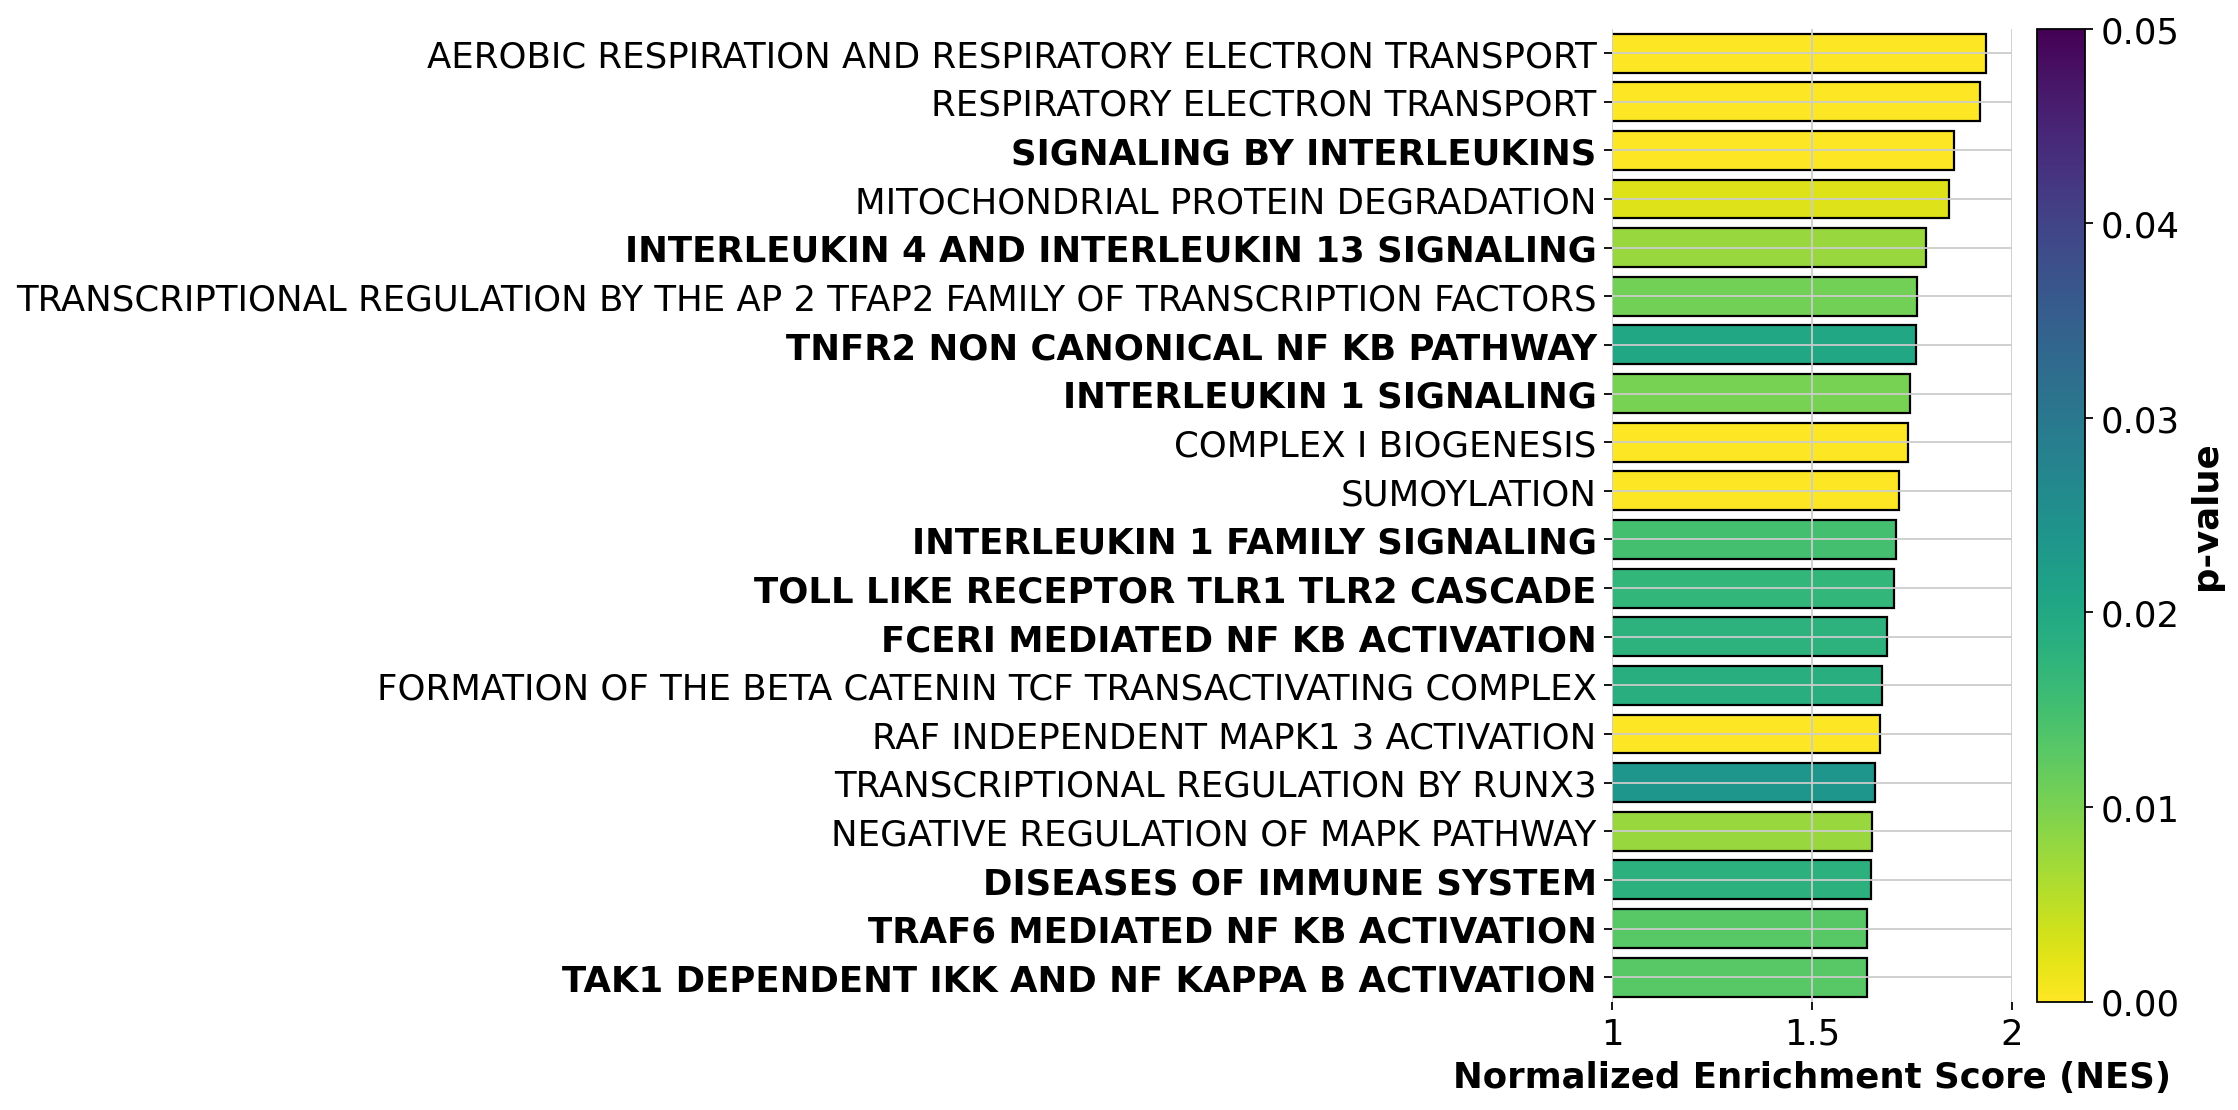

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable

# Pathways you want in bold
bold_pathways = [
    "SIGNALING BY INTERLEUKINS", 
    "INTERLEUKIN 4 AND INTERLEUKIN 13 SIGNALING",
    "TNFR2 NON CANONICAL NF KB PATHWAY",
    "INTERLEUKIN 1 SIGNALING",
    "INTERLEUKIN 1 FAMILY SIGNALING",
    "TOLL LIKE RECEPTOR TLR1 TLR2 CASCADE",
    "FCERI MEDIATED NF KB ACTIVATION",
    "DISEASES OF IMMUNE SYSTEM",
    "TAK1 DEPENDENT IKK AND NF KAPPA B ACTIVATION",
    "TRAF6 MEDIATED NF KB ACTIVATION",
    "PD 1 SIGNALING",
    "MHC CLASS II ANTIGEN PRESENTATION",
    "ADORA2B MEDIATED ANTI INFLAMMATORY CYTOKINES PRODUCTION",
    "NEUTROPHIL DEGRANULATION"
]

# 1) Filter p < 0.05 and norm > 0
sig_gsea = gsea_results[(gsea_results["pval"] < 0.05) & (gsea_results["norm"] > 0)].copy()

# 2) Take top 25 by ascending p-value
sig_gsea = sig_gsea.sort_values("pval").head(25)

# 3) Sort these 25 by norm in ASCENDING order (smallest to largest)
sig_gsea = sig_gsea.sort_values("norm", ascending=True)

# 4) Remove the first 5 rows => these are the smallest norms in this subset
sig_gsea = sig_gsea.iloc[5:]  

# Clean pathway names: remove "REACTOME_", replace underscores
sig_gsea.index = (
    sig_gsea.index
    .str.replace(r"^REACTOME_", "", regex=True)
    .str.replace("_", " ")
)

# Maintain font sizes
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# We'll map p-values to colors
pval_min, pval_max = 0.0, 0.05
cmap = sns.color_palette("viridis_r", as_cmap=True)

def pval_to_color(p):
    # Clip p-values into [pval_min, pval_max]
    p_clipped = np.clip(p, pval_min, pval_max)
    t = (p_clipped - pval_min) / (pval_max - pval_min)
    return cmap(t)

colors = [pval_to_color(p) for p in sig_gsea["pval"]]

# 5) Plot in a figure that is narrower (width=8, height=9)
fig, ax = plt.subplots(figsize=(4, 8))

# Horizontal bar plot
y_positions = np.arange(len(sig_gsea))
ax.barh(
    y_positions,
    width=sig_gsea["norm"],
    color=colors,
    edgecolor="black"
)

# Reference line at x=0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set_xlabel("Normalized Enrichment Score (NES)", fontweight="bold")
ax.set_ylabel("")

# Y-axis ticks
ax.set_yticks(y_positions)
ax.set_yticklabels(sig_gsea.index, fontweight="normal")

# Make certain pathways bold
for label in ax.get_yticklabels():
    if label.get_text() in bold_pathways:
        label.set_fontweight("bold")

# Remove spines for a cleaner look
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# Make sure bars aren't cut off
ax.set_ylim(-0.5, len(sig_gsea) - 0.5)

# Restrict x-axis from 1 to 2 and place ticks at [1, 1.5, 2]
ax.set_xlim(1, 2)
ax.set_xticks([1, 1.5, 2])
ax.set_xticklabels(["1", "1.5", "2"])

# Colorbar for p-values
norm = plt.Normalize(vmin=pval_min, vmax=pval_max)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("p-value", fontweight="bold")

plt.tight_layout()

plt.savefig("250301_GSEA_top20_largest_norm_narrow.svg", format="svg", dpi=300)  # Uncomment to save
plt.show()
